In [1]:
import timeit
start_time = timeit.default_timer()

In [2]:
## Import libraries
import time
import datetime
import pandas as pd
import io
import matplotlib.pyplot as plt

# GSEF forecast

In [3]:
gsef= pd.read_csv('gsef_folder/historical_gsef.csv', parse_dates=['Date'], dayfirst=True)

This analysis demonstrates the use of ARIMA models to predict the prices of the NN (L) Global Sustainable Equity fund.

## Imports & data loading

In [4]:
import pmdarima as pm
from pmdarima.model_selection import train_test_split
import numpy as np

In [5]:
gsef_selected= gsef[['Date','Close']]

In [6]:
y = gsef_selected['Close'].values

## Data splitting

In [7]:
train_data, test_data = gsef_selected[0:int(len(gsef_selected)*0.65)], gsef_selected[int(len(gsef_selected)*0.65):]

# Load/split your data
y_train, y_test = train_test_split(y, train_size= len(train_data))

## Pre-modeling analysis

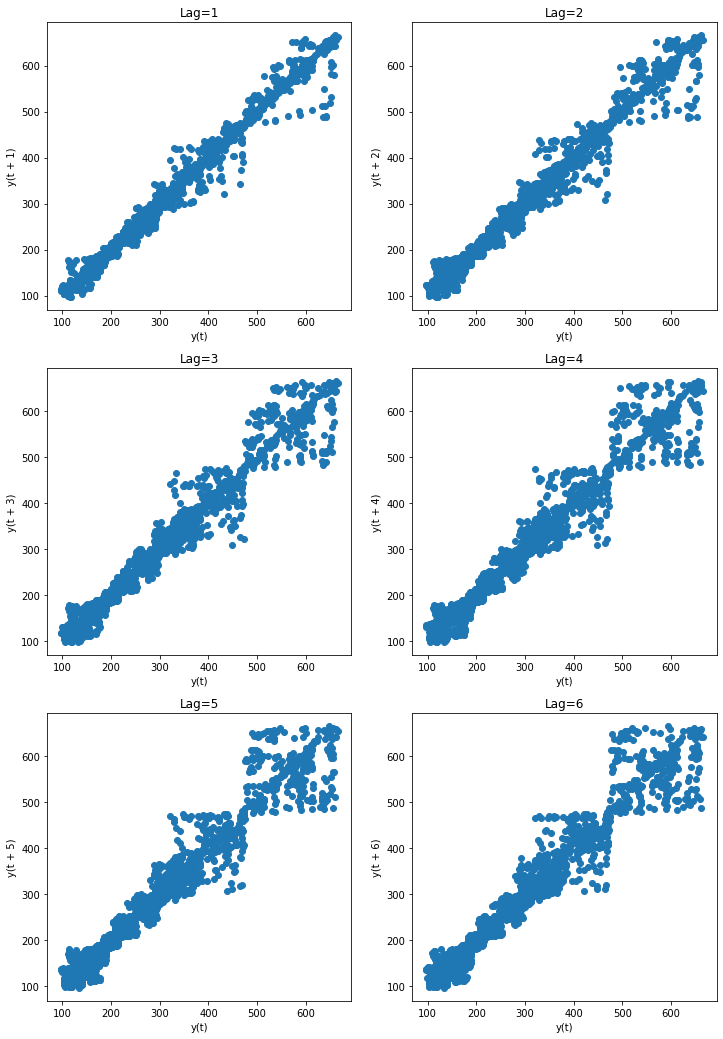

In [8]:
from pandas.plotting import lag_plot

fig, axes = plt.subplots(3, 2, figsize=(12, 18))
plt.title('GSEF Autocorrelation plot')

# The axis coordinates for the plots
ax_idcs = [
    (0, 0),
    (0, 1),
    (1, 0),
    (1, 1),
    (2, 0),
    (2, 1)
]

for lag, ax_coords in enumerate(ax_idcs, 1):
    ax_row, ax_col = ax_coords
    axis = axes[ax_row][ax_col]
    lag_plot(gsef_selected['Close'], lag=lag, ax=axis)
    axis.set_title(f"Lag={lag}")

#plt.show()

## Estimating the differencing term

In [9]:
from pmdarima.arima import ndiffs

kpss_diffs = ndiffs(y_train, alpha=0.05, test='kpss', max_d=6)
adf_diffs = ndiffs(y_train, alpha=0.05, test='adf', max_d=6)
n_diffs = max(adf_diffs, kpss_diffs)

print(f"Estimated differencing term: {n_diffs}")

Estimated differencing term: 1


## Fitting our model

In [10]:
auto = pm.auto_arima(y_train, d=n_diffs, seasonal=True, stepwise=True,
                     suppress_warnings=True, error_action="ignore", max_p=6,
                     max_order=None, trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=21607.496, Time=2.31 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=22078.765, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=21928.337, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=21881.899, Time=0.33 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=22076.878, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=21605.932, Time=1.14 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=21826.076, Time=0.55 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=21609.223, Time=0.95 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=21606.000, Time=1.50 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=21760.990, Time=0.84 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=21605.587, Time=1.24 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=21876.085, Time=0.18 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=21607.099, Time=1.51 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=21871.297, Time=0.46 sec
 ARIMA(3,1,2)(0,0,0

## Updating the model

In [11]:
from sklearn.metrics import mean_squared_error
from pmdarima.metrics import smape

model = auto  # seeded from the model we've already fit

def forecast_one_step():
    fc, conf_int = model.predict(n_periods=1, return_conf_int=True)
    return (
        fc.tolist()[0],
        np.asarray(conf_int).tolist()[0])

forecasts = []
confidence_intervals = []

for new_ob in y_test:
    fc, conf = forecast_one_step()
    forecasts.append(fc)
    confidence_intervals.append(conf)

    # Updates the existing model with a small number of MLE steps
    model.update(new_ob)

print(f"Mean squared error: {mean_squared_error(y_test, forecasts)}")
print(f"SMAPE: {smape(y_test, forecasts)}")

Mean squared error: 376.64339682490544
SMAPE: 2.550993971706971


In [12]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 4595
Model:               SARIMAX(2, 1, 1)   Log Likelihood              -17967.185
Date:                Sat, 09 Apr 2022   AIC                          35944.369
Time:                        13:35:31   BIC                          35976.532
Sample:                             0   HQIC                         35955.690
                               - 4595                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0287      0.009      3.288      0.001       0.012       0.046
ar.L1          0.7084      0.008     90.784      0.000       0.693       0.724
ar.L2      -1.487e-05      0.009     -0.002      0.999      -0.018       0.018
ma.L1         -0.9577      0.004   -233.363      0.000      -0.966      -0.950
sigma2       146.1317      0.939    155.691      0.000     144.292     147.971
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):            144416.58
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               6.63   Skew:                            -1.90
Prob(H) (two-sided):                  0.00   Kurtosis:                        30.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Viewing forecasts

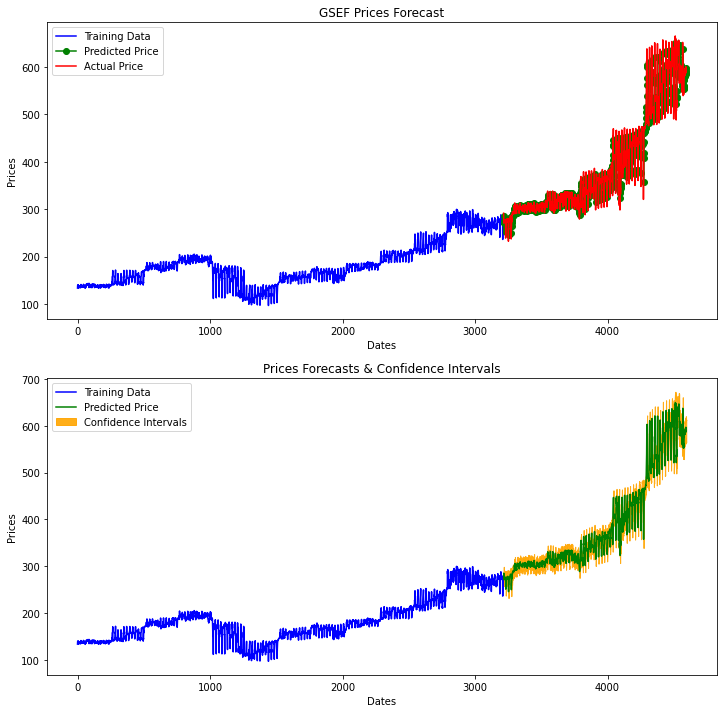

In [13]:
fig, axes = plt.subplots(2, 1, figsize=(12, 12))

# --------------------- Actual vs. Predicted --------------------------
axes[0].plot(y_train, color='blue', label='Training Data')
axes[0].plot(test_data.index, forecasts, color='green', marker='o',
             label='Predicted Price')

axes[0].plot(test_data.index, y_test, color='red', label='Actual Price')
axes[0].set_title('GSEF Prices Forecast')
axes[0].set_xlabel('Dates')
axes[0].set_ylabel('Prices')


axes[0].legend()


# ------------------ Predicted with confidence intervals ----------------
axes[1].plot(y_train, color='blue', label='Training Data')
axes[1].plot(test_data.index, forecasts, color='green',
             label='Predicted Price')

axes[1].set_title('Prices Forecasts & Confidence Intervals')
axes[1].set_xlabel('Dates')
axes[1].set_ylabel('Prices')

conf_int = np.asarray(confidence_intervals)
axes[1].fill_between(test_data.index,
                     conf_int[:, 0], conf_int[:, 1],
                     alpha=0.9, color='orange',
                     label="Confidence Intervals")

axes[1].legend()

## Forecast the Price for the next 10 business days

In [14]:
# Forecast the Priece for the next 10 business days
forecast= model.predict(start= len(gsef_selected), end= len(gsef_selected)+10, type= 'levels')

following_day= gsef_selected.Date.iloc[-1]+ pd.DateOffset(1)

index_future_dates= pd.date_range(start= following_day, periods=10, freq='B')

forecast_df = pd.DataFrame(forecast, columns = ['Close'], index= pd.DatetimeIndex(index_future_dates)).reset_index(level=0)

forecast_df.rename(columns={'index': 'Date'}, inplace=True)

existing_with_forecast= pd.concat([gsef_selected, forecast_df], ignore_index=True, sort=False)

## Visualise and save the forecasts

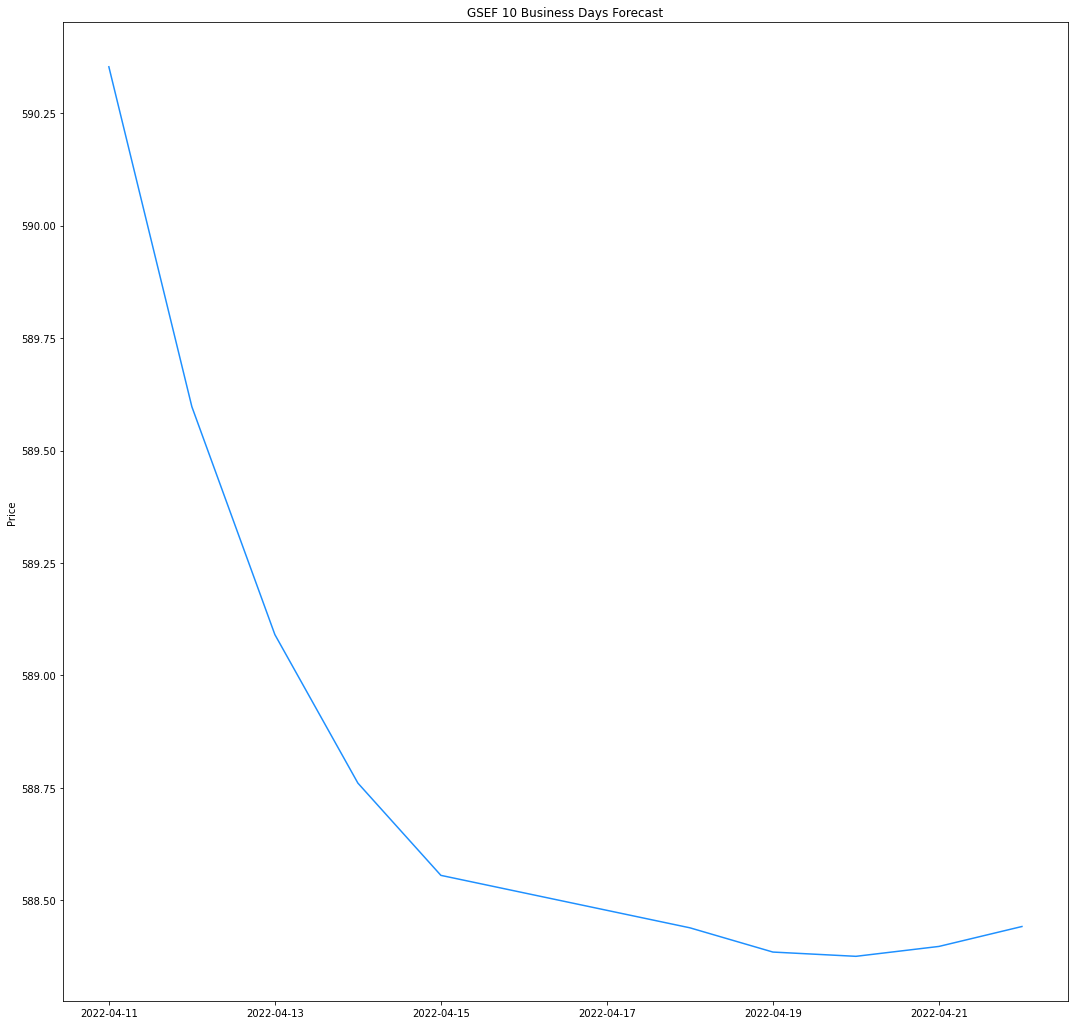

In [15]:
#plt.plot(existing_with_forecast['Date'][:-10], existing_with_forecast['Close'][:-10], color='crimson')

plt.figure(figsize=(12, 8))

plt.plot(existing_with_forecast['Date'][-10:], existing_with_forecast['Close'][-10:], color='dodgerblue')

plt.ylabel('Price')

plt.title('GSEF 10 Business Days Forecast')

forecast_chart= 'gsef_folder/gsef_10_day_forecast.png'

import os
if os.path.exists(forecast_chart):
  os.remove(forecast_chart)
else:
  print("The Forecast chart didn't exist and it has been created.")

plt.savefig('gsef_folder/gsef_10_day_forecast.png', dpi=100)

#plt.show()

## Time Elapsed

In [16]:
# Calculate and print the time elapsed to run ETL process and the date and time of the latest run
time_elapsed = timeit.default_timer() - start_time

time_elapsed_minutes = int((time_elapsed % 3600) // 60)

time_elapsed_seconds = int(time_elapsed % 60)

now = datetime.datetime.now()

print("\n Success! Your GSEF forecast has been updated in {} minutes and {} seconds on {}".format(time_elapsed_minutes, time_elapsed_seconds, now.strftime("%Y-%m-%d %H:%M:%S")))


 Success! Your GSEF forecast has been updated in 12 minutes and 34 seconds on 2022-04-09 13:35:33
